# Trees
Archives are stored as trees. A node in the tree may represent 
- a _piece_ (eg an individual bit of the archive subject's correspondence), 
- an _item_ (typical leaf node in the tree, usually a box containing multiple pieces), 
- a _section_, _series_, _subsection_, _subsubseries_, _subsubsubseries_ etc describing the informational hierarchy though which context can be attributed to items and the collection as a whole can be understood, 
- a _collection_, representing the top of the tree and the point at which no context is shared between records of the same rank. 

The CALM data contains many collection level records, some of which are also contextually linked. All of these nodes in the trees are stored as individual rows in the CALM `.json`, and their positions in the hierarchy are described by the `AltRefNo` field. Let's open some up and have a look at their structure.

In [38]:
from IPython.core.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (30, 30)

import pandas as pd
import numpy as np
import networkx as nx

import re

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm_notebook as tqdm

In [39]:
df = pd.read_json('data/calm_records.json')

In [40]:
df['AltRefNo']

0                 [PP/STR/C.10]
1         [WA/HMM/ST/Lat/A.163]
2          [WA/HMM/ST/Lat/A.81]
3          [WA/HMM/ST/Lat/A.65]
4          [WA/HMM/ST/Lat/A.31]
5               [PP/FPW/D.11/8]
6         [WA/HMM/ST/Lat/A.227]
7                   [WA/CRL/HI]
8               [PP/FPW/D.11/7]
9            [WA/PHO/Kel/A.4/6]
10                [PP/FPW/D.10]
11           [WA/PHO/Kel/B.4/2]
12               [PP/FPW/B.245]
13                 [PP/FPW/C.5]
14          [WA/HMM/CO/Ear/344]
15               [WA/TRL/Pub/B]
16                [WA/HSW/DI/1]
17                [WA/HSW/OR/M]
18                [WA/HSW/MO/B]
19         [WA/HMM/ST/Lat/A.23]
20            [WA/HMM/TR/Abc/A]
21           [WA/HMM/CM/Not/63]
22            [WA/HSW/CO/Gen/C]
23           [WA/PHO/Kel/A.3/6]
24                [WA/HSW/FP/H]
25            [WA/HMM/CO/Chr/A]
26               [PP/FPW/C.4/2]
27           [WA/PHO/Kel/A.6/1]
28              [WA/BSR/BA/Sta]
29            [WA/HMM/CO/Chr/E]
                  ...          
269081  

The `Level` field tells us whether the record is an item, a series, a subsubsection etc. However, I'm going to ignore this as the choice of when to use these hierarchy descriptors is somewhat arbitrary, chosen by the archivist in question to best fit the archive. I'm told that what _really_ matters is the _structure_ of the archive, which is all contained in the `AltRefNo`s.  
We can obtain a little extra useful context from some of these records. The _arrangement_ of each collection is described in the `Arrangement` field of a collection-level record. However, these are inconsistently written and are unlikely to be machine-interpretable any time soon. Still, good to know that they're there

In [41]:
display(HTML(df['Arrangement'][269057][0]))

The `.json` format adds some noise to data when read into pandas. Let's quickly clean up some of the more useful fields. 

In [42]:
df['AltRefNo'] = df['AltRefNo'].dropna().apply(lambda x: x[0])
df['Level'] = df['Level'].dropna().apply(lambda x: x[0])

### building a tree
Let's take a look at some of the collection-level records' `AltRefNo`s and use one of them as a starting point for our tree building

In [6]:
for collection_id in sorted(df['AltRefNo'][df['Level'] == 'Collection'].values):
    print(collection_id)

2620
3473
7267
8855
AAU/FAS
AML
AMS/MF/2
AMS/MF/3
AMS/MF/4
AMS/MF/6
ART/AFH
ART/COO
ART/GEO
ART/IOW
ART/LAB
ART/MIW
ART/SAH
ART/WIT
DGH1
GALTON
GC/1
GC/10
GC/100
GC/101
GC/102
GC/103
GC/104
GC/105
GC/106
GC/107
GC/108
GC/109
GC/110
GC/116
GC/118
GC/119
GC/12
GC/120
GC/121
GC/124
GC/125
GC/127
GC/13
GC/130
GC/131
GC/132
GC/133
GC/134
GC/135
GC/136
GC/137
GC/138
GC/139
GC/14
GC/140
GC/141
GC/142
GC/143
GC/144
GC/145
GC/146
GC/147
GC/148
GC/149
GC/150
GC/151
GC/152
GC/153
GC/154
GC/155
GC/157
GC/158
GC/16
GC/160
GC/161
GC/162
GC/163
GC/164
GC/165
GC/168
GC/169
GC/170
GC/171
GC/172
GC/175
GC/176
GC/177
GC/178
GC/179
GC/18
GC/180
GC/181
GC/182
GC/183
GC/185
GC/186
GC/187
GC/188
GC/189
GC/19
GC/190
GC/191
GC/192
GC/193
GC/195
GC/197
GC/198
GC/199
GC/2
GC/20
GC/200
GC/201
GC/203
GC/205
GC/207
GC/208
GC/209
GC/21
GC/210
GC/213
GC/214
GC/215
GC/216
GC/218
GC/219
GC/220
GC/222
GC/223
GC/224
GC/226
GC/227
GC/228
GC/23
GC/231
GC/233
GC/236
GC/237
GC/238
GC/239
GC/240
GC/241
GC/244
GC/248
GC/249
GC

In [70]:
alt_ref_no = 'PP/CRI'

We want to find every record in the DataFrame whose `AltRefNo`s start with the chosen string above:

In [71]:
codes_as_str = sorted(df['AltRefNo'][df['AltRefNo']
                                     .str.startswith(alt_ref_no)
                                     .fillna(False)]
                      .tolist())
codes_as_str

['PP/CRI/A',
 'PP/CRI/A/1',
 'PP/CRI/A/1/1',
 'PP/CRI/A/1/2',
 'PP/CRI/A/1/2/1',
 'PP/CRI/A/1/2/2',
 'PP/CRI/A/1/2/3',
 'PP/CRI/A/1/2/4',
 'PP/CRI/A/1/2/5',
 'PP/CRI/A/1/2/6',
 'PP/CRI/A/1/2/7',
 'PP/CRI/A/1/2/8',
 'PP/CRI/A/1/2/9',
 'PP/CRI/A/1/3',
 'PP/CRI/A/1/4',
 'PP/CRI/A/1/5',
 'PP/CRI/A/1/6',
 'PP/CRI/A/1/6/1',
 'PP/CRI/A/1/6/2',
 'PP/CRI/A/2',
 'PP/CRI/A/2/1',
 'PP/CRI/A/2/2',
 'PP/CRI/A/2/3',
 'PP/CRI/A/2/4',
 'PP/CRI/A/2/5',
 'PP/CRI/A/3',
 'PP/CRI/A/3/1',
 'PP/CRI/A/3/1/1',
 'PP/CRI/A/3/1/2',
 'PP/CRI/A/3/1/3',
 'PP/CRI/A/3/1/4',
 'PP/CRI/A/3/1/5',
 'PP/CRI/A/3/1/6',
 'PP/CRI/A/3/1/7',
 'PP/CRI/A/3/2',
 'PP/CRI/A/3/2/1',
 'PP/CRI/A/3/2/2',
 'PP/CRI/A/3/3',
 'PP/CRI/A/3/3/1',
 'PP/CRI/A/3/3/2',
 'PP/CRI/A/3/4',
 'PP/CRI/A/3/5',
 'PP/CRI/A/3/6',
 'PP/CRI/A/3/7',
 'PP/CRI/A/4',
 'PP/CRI/A/4/1',
 'PP/CRI/A/4/2',
 'PP/CRI/A/4/3',
 'PP/CRI/A/4/4',
 'PP/CRI/A/4/5',
 'PP/CRI/A/4/6',
 'PP/CRI/B',
 'PP/CRI/B/1',
 'PP/CRI/B/1/1',
 'PP/CRI/B/1/2',
 'PP/CRI/B/1/3',
 'PP/CRI/B/1/4',
 'PP/

We'll now clean up the split those codes into lists of parts, using each `/` or `.` as delimiters. We'll then stick these strings and lists into a dictionary together - this is going to be useful in a minute...

In [72]:
codes = {code: re.split('/|\.', code.strip()) 
         for code in codes_as_str}

codes

{'PP/CRI/A': ['PP', 'CRI', 'A'],
 'PP/CRI/A/1': ['PP', 'CRI', 'A', '1'],
 'PP/CRI/A/1/1': ['PP', 'CRI', 'A', '1', '1'],
 'PP/CRI/A/1/2': ['PP', 'CRI', 'A', '1', '2'],
 'PP/CRI/A/1/2/1': ['PP', 'CRI', 'A', '1', '2', '1'],
 'PP/CRI/A/1/2/2': ['PP', 'CRI', 'A', '1', '2', '2'],
 'PP/CRI/A/1/2/3': ['PP', 'CRI', 'A', '1', '2', '3'],
 'PP/CRI/A/1/2/4': ['PP', 'CRI', 'A', '1', '2', '4'],
 'PP/CRI/A/1/2/5': ['PP', 'CRI', 'A', '1', '2', '5'],
 'PP/CRI/A/1/2/6': ['PP', 'CRI', 'A', '1', '2', '6'],
 'PP/CRI/A/1/2/7': ['PP', 'CRI', 'A', '1', '2', '7'],
 'PP/CRI/A/1/2/8': ['PP', 'CRI', 'A', '1', '2', '8'],
 'PP/CRI/A/1/2/9': ['PP', 'CRI', 'A', '1', '2', '9'],
 'PP/CRI/A/1/3': ['PP', 'CRI', 'A', '1', '3'],
 'PP/CRI/A/1/4': ['PP', 'CRI', 'A', '1', '4'],
 'PP/CRI/A/1/5': ['PP', 'CRI', 'A', '1', '5'],
 'PP/CRI/A/1/6': ['PP', 'CRI', 'A', '1', '6'],
 'PP/CRI/A/1/6/1': ['PP', 'CRI', 'A', '1', '6', '1'],
 'PP/CRI/A/1/6/2': ['PP', 'CRI', 'A', '1', '6', '2'],
 'PP/CRI/A/2': ['PP', 'CRI', 'A', '2'],
 'PP/CRI/A/

### Graph theory and NetworkX
Seeing these lists in sorted order and thinking of them as implicit descriptions of a POSIX-style directory/folder structure, it's easy to see how the archive is divided into a hierarchy. All we need to do now is re-encode that hierarchy explicitly. To do that, we'll use a python package called NetworkX, which allows us to do a lot of basic graph theory (and some complex stuff too).  
As we learned in the last notebook, almost all of graph theory is based on something called an _adjacency matrix_, which describes the links between each node in the network. Each column/row represents a single node, and their intersection represents the strength of the interaction between them. Let's construct an empty matrix which we'll then populate based on the `AltRefNo` information.

In [73]:
adjacency = pd.DataFrame(data=0, 
                         index=codes_as_str, 
                         columns=codes_as_str)

We'll now iterate through all of the possible `AltRefNo` string/list pairs. If the pair look like they have a parent/child relationship (the child's `AltRefNo` list is one element longer than the parent's and contains the full parent `AltRefNo`), then we change the element from a `0` to a `1`, drawing a connection between them.

In [74]:
for parent_str, parent_list in tqdm(codes.items()):
    for child_str, child_list in codes.items():
        if child_list == parent_list + [child_list[-1]]:
            adjacency[parent_str][child_str] += 1

HBox(children=(IntProgress(value=0, max=2678), HTML(value='')))

We can look at the number of connections drawn out of the $n^{2}$ potential connections.

In [75]:
pd.Series(np.hstack(adjacency.values)).value_counts()

0    7169020
1       2664
dtype: int64

Recent versions of NetworkX can build a graph from the raw adjacency matrix in pandas DataFrame format, inferring all node names etc.

In [76]:
G = nx.from_pandas_adjacency(adjacency)

we can now draw our network!

In [82]:
adjacency

,PP/CRI/A,PP/CRI/A/1,PP/CRI/A/1/1,PP/CRI/A/1/2,PP/CRI/A/1/2/1,PP/CRI/A/1/2/2,PP/CRI/A/1/2/3,PP/CRI/A/1/2/4,PP/CRI/A/1/2/5,PP/CRI/A/1/2/6,...,PP/CRI/N/2,PP/CRI/N/3,PP/CRI/N/4,PP/CRI/N/5,PP/CRI/N/6,PP/CRI/N/7,PP/CRI/N/7/1,PP/CRI/N/7/2,PP/CRI/N/8,PP/CRI/N/9
PP/CRI/A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2/1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2/2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2/3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2/4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2/5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PP/CRI/A/1/2/6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


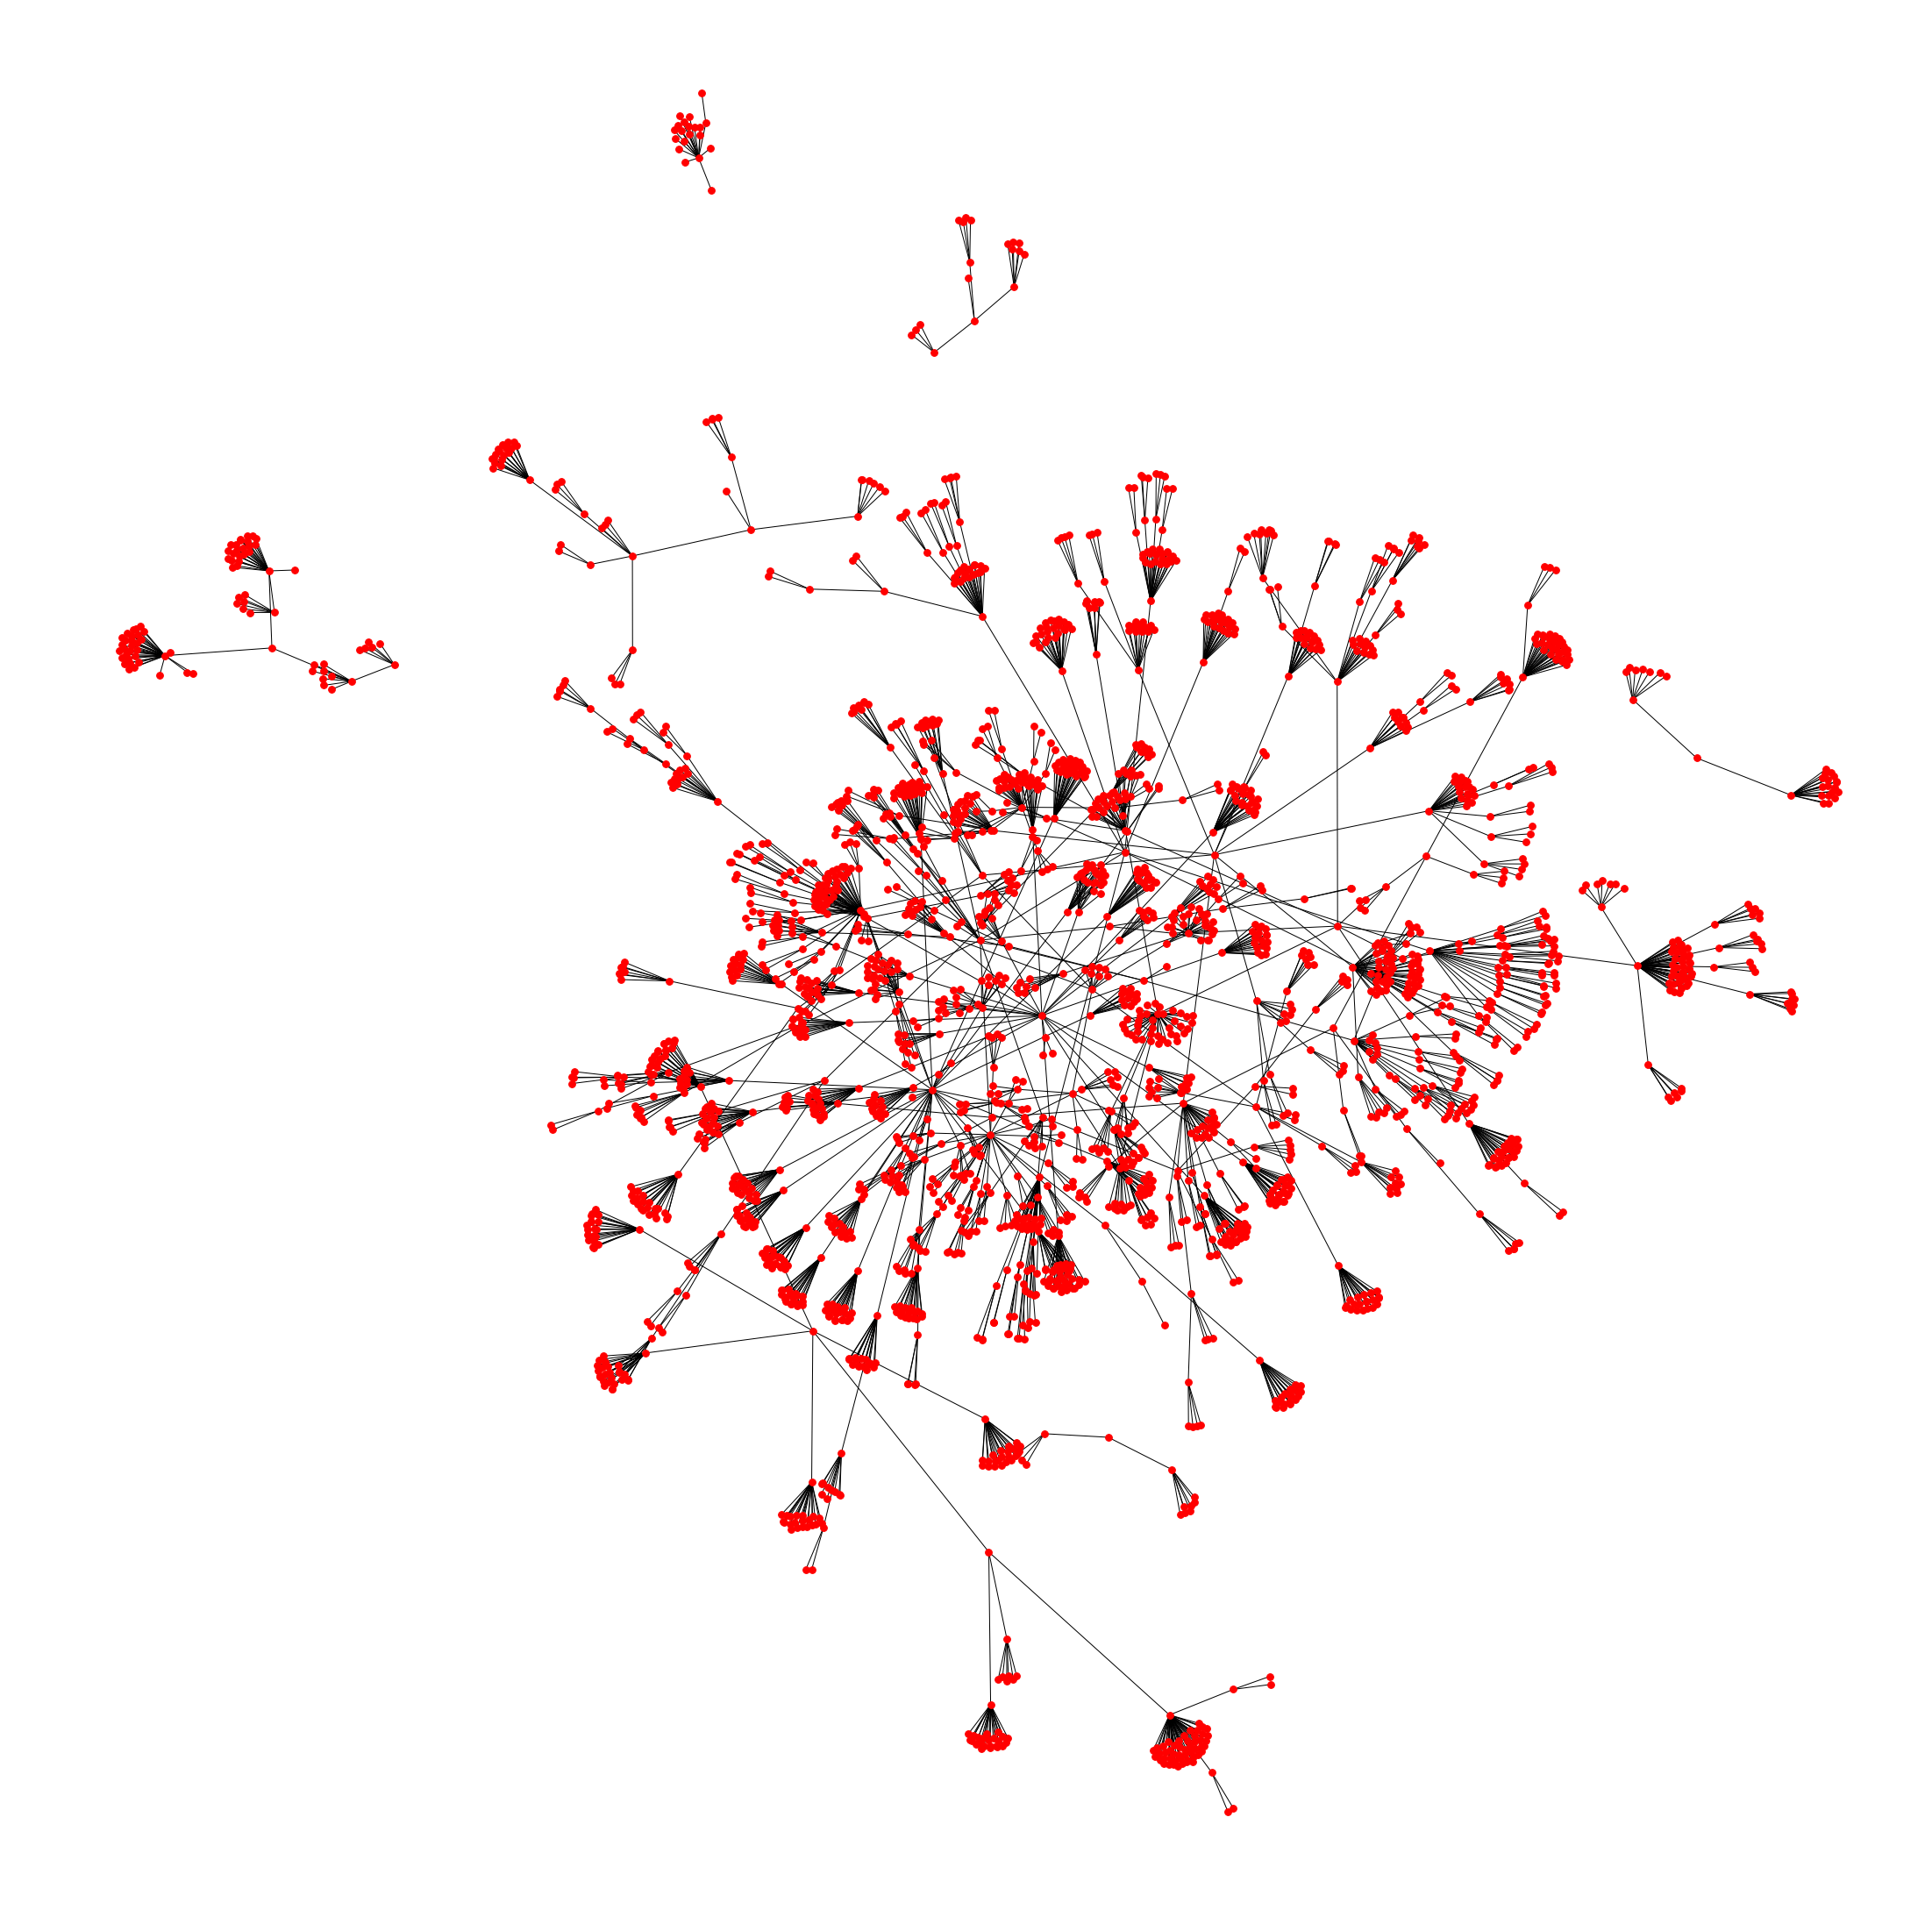

In [77]:
nx.draw_spring(G, node_size=60)

As shown in the last notebook, we don't have to see adjacency matrices as graphs - they can also be seen as $n$ dimensional spaces, where each $n$D vector describes a position in that space. We can reduce the dimensionality of each vector while preserving as many of the distances between points as possible. UMAP provides a great way of doing this, but other techniques such as PCA and t-SNE also exist. We'll now squish our $n$D vector space down onto a 2D plane using UMAP. Here's what our graph looks like in that free-form 2D space.

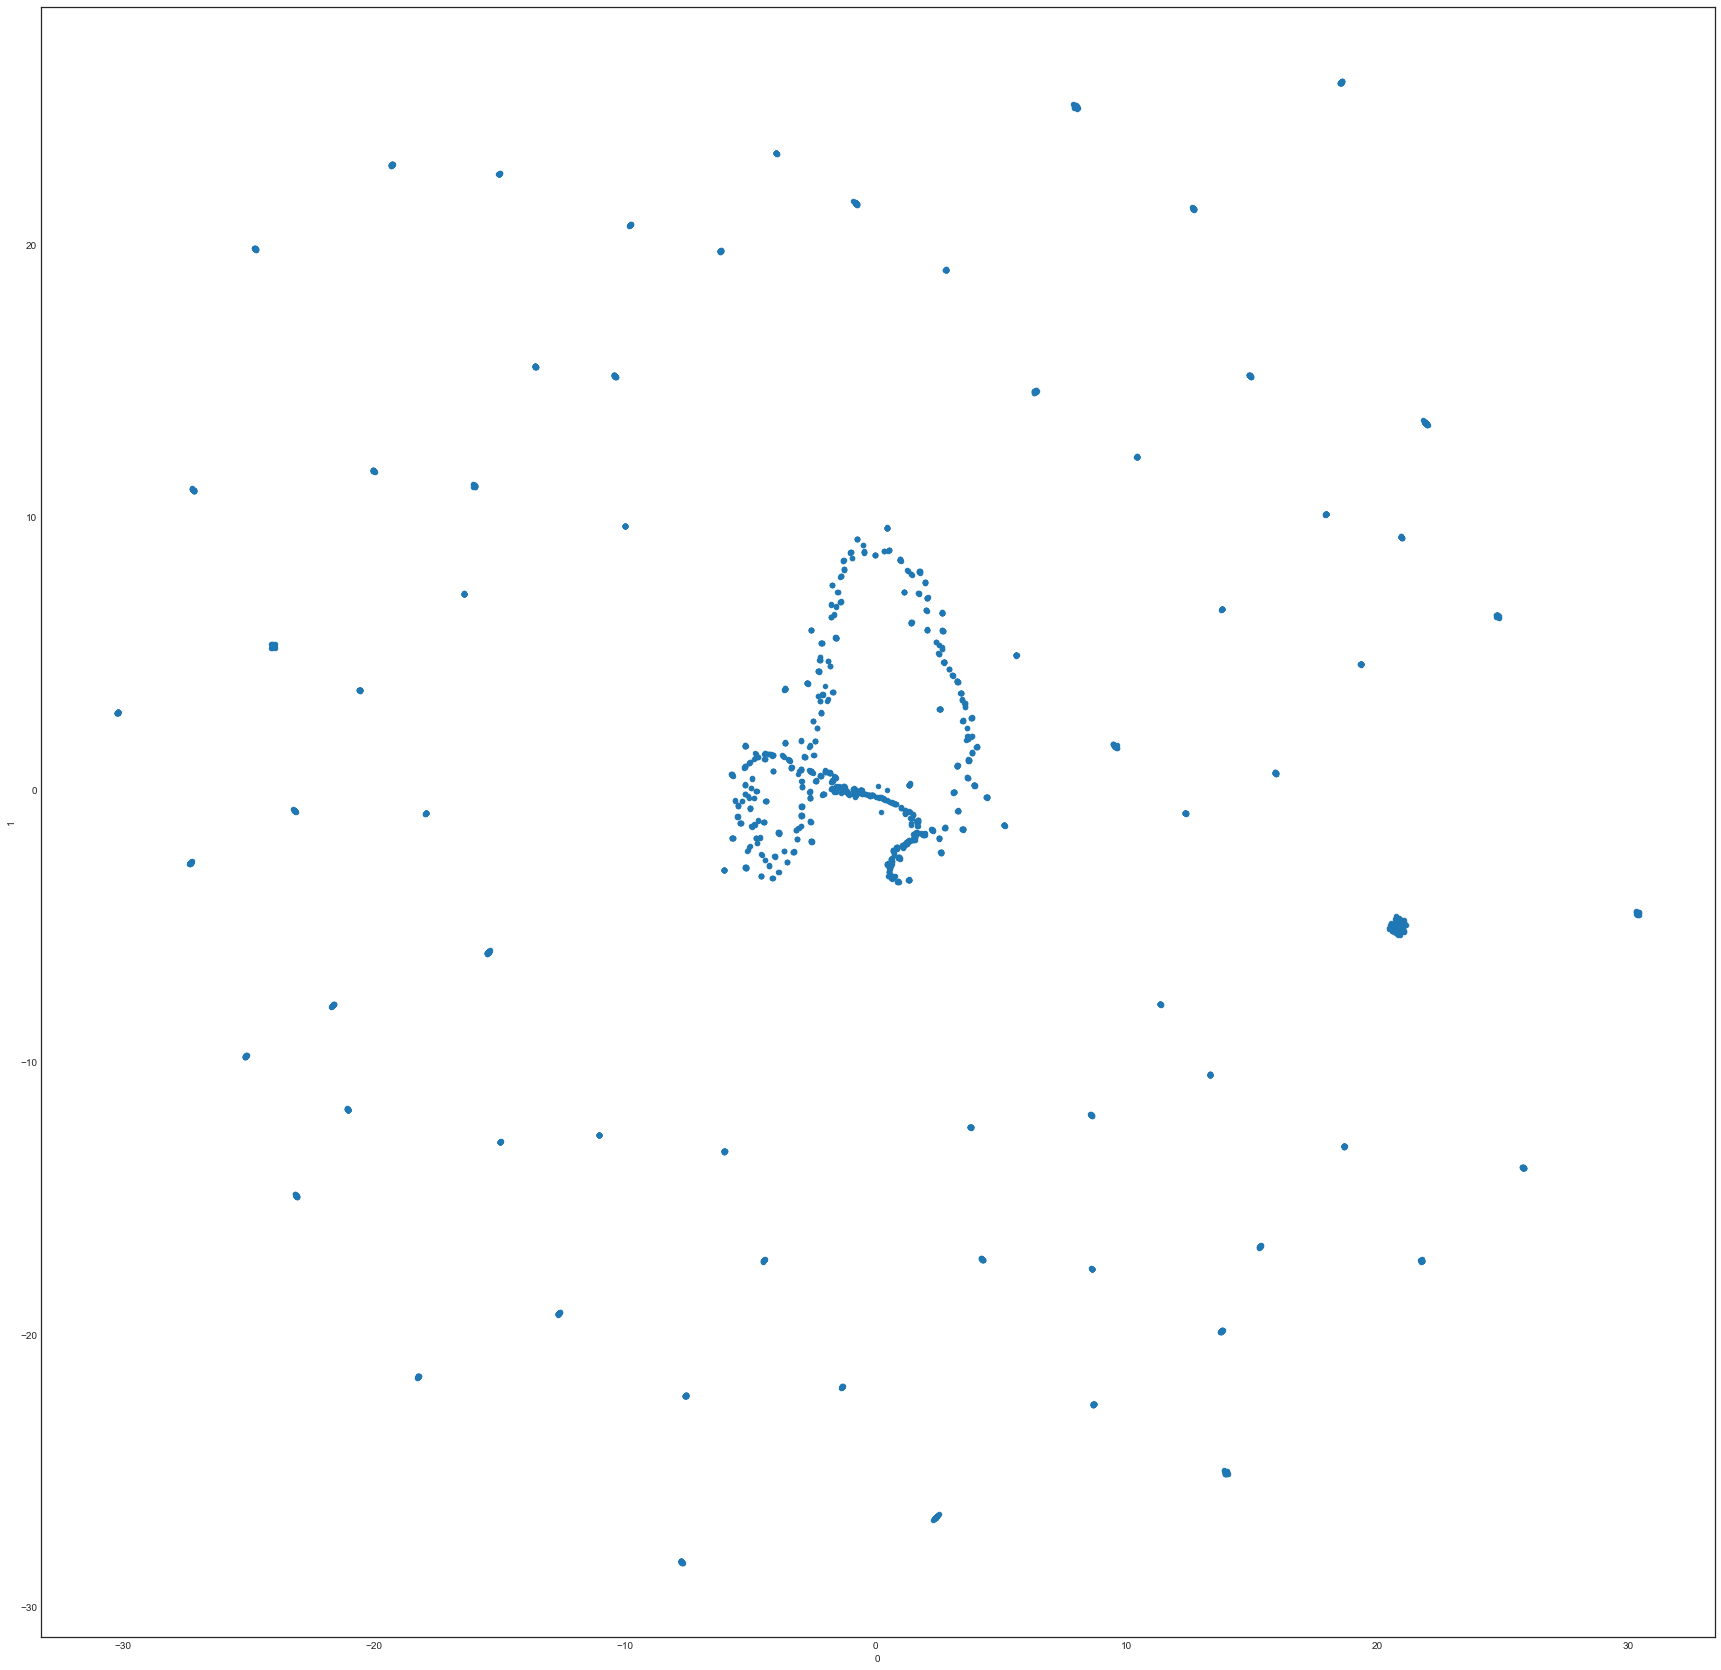

In [60]:
embedding_2d = pd.DataFrame(UMAP(n_components=2)
                            .fit_transform(adjacency))

embedding_2d.plot.scatter(x=0, y=1);

We can use all sorts of techniques to group these points into distinct clusters. Here we'll use agglomerative clustering again

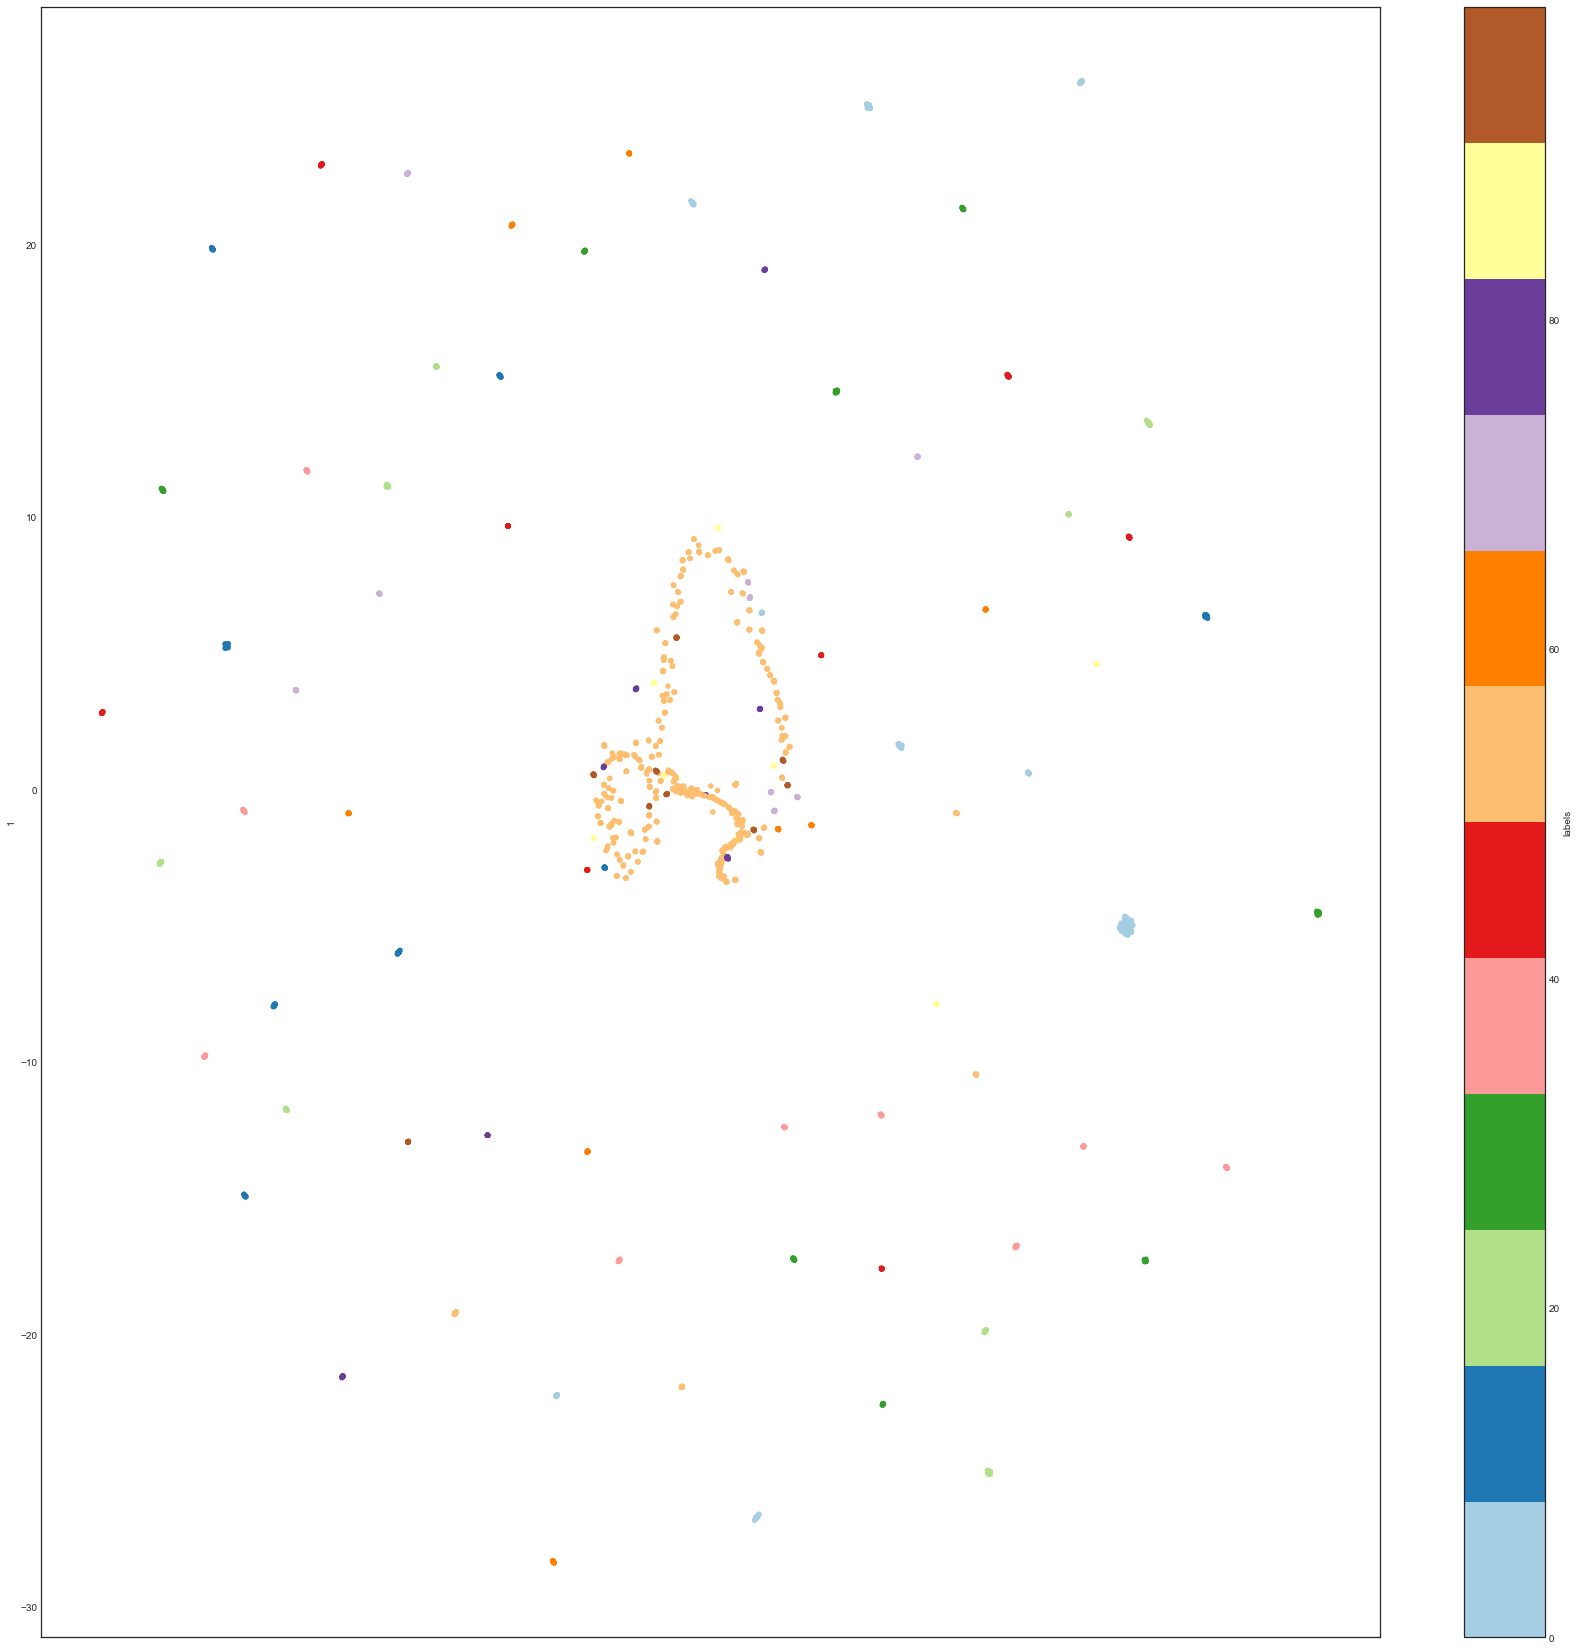

In [67]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans


n_clusters = 100
embedding_2d['labels'] = KMeans(n_clusters).fit_predict(adjacency.values)
embedding_2d.plot.scatter(x=0, y=1, c='labels', cmap='Paired');

now we can map those cluster labels back onto our graph nodes, colouring them according to the points with which they share a common feature space.

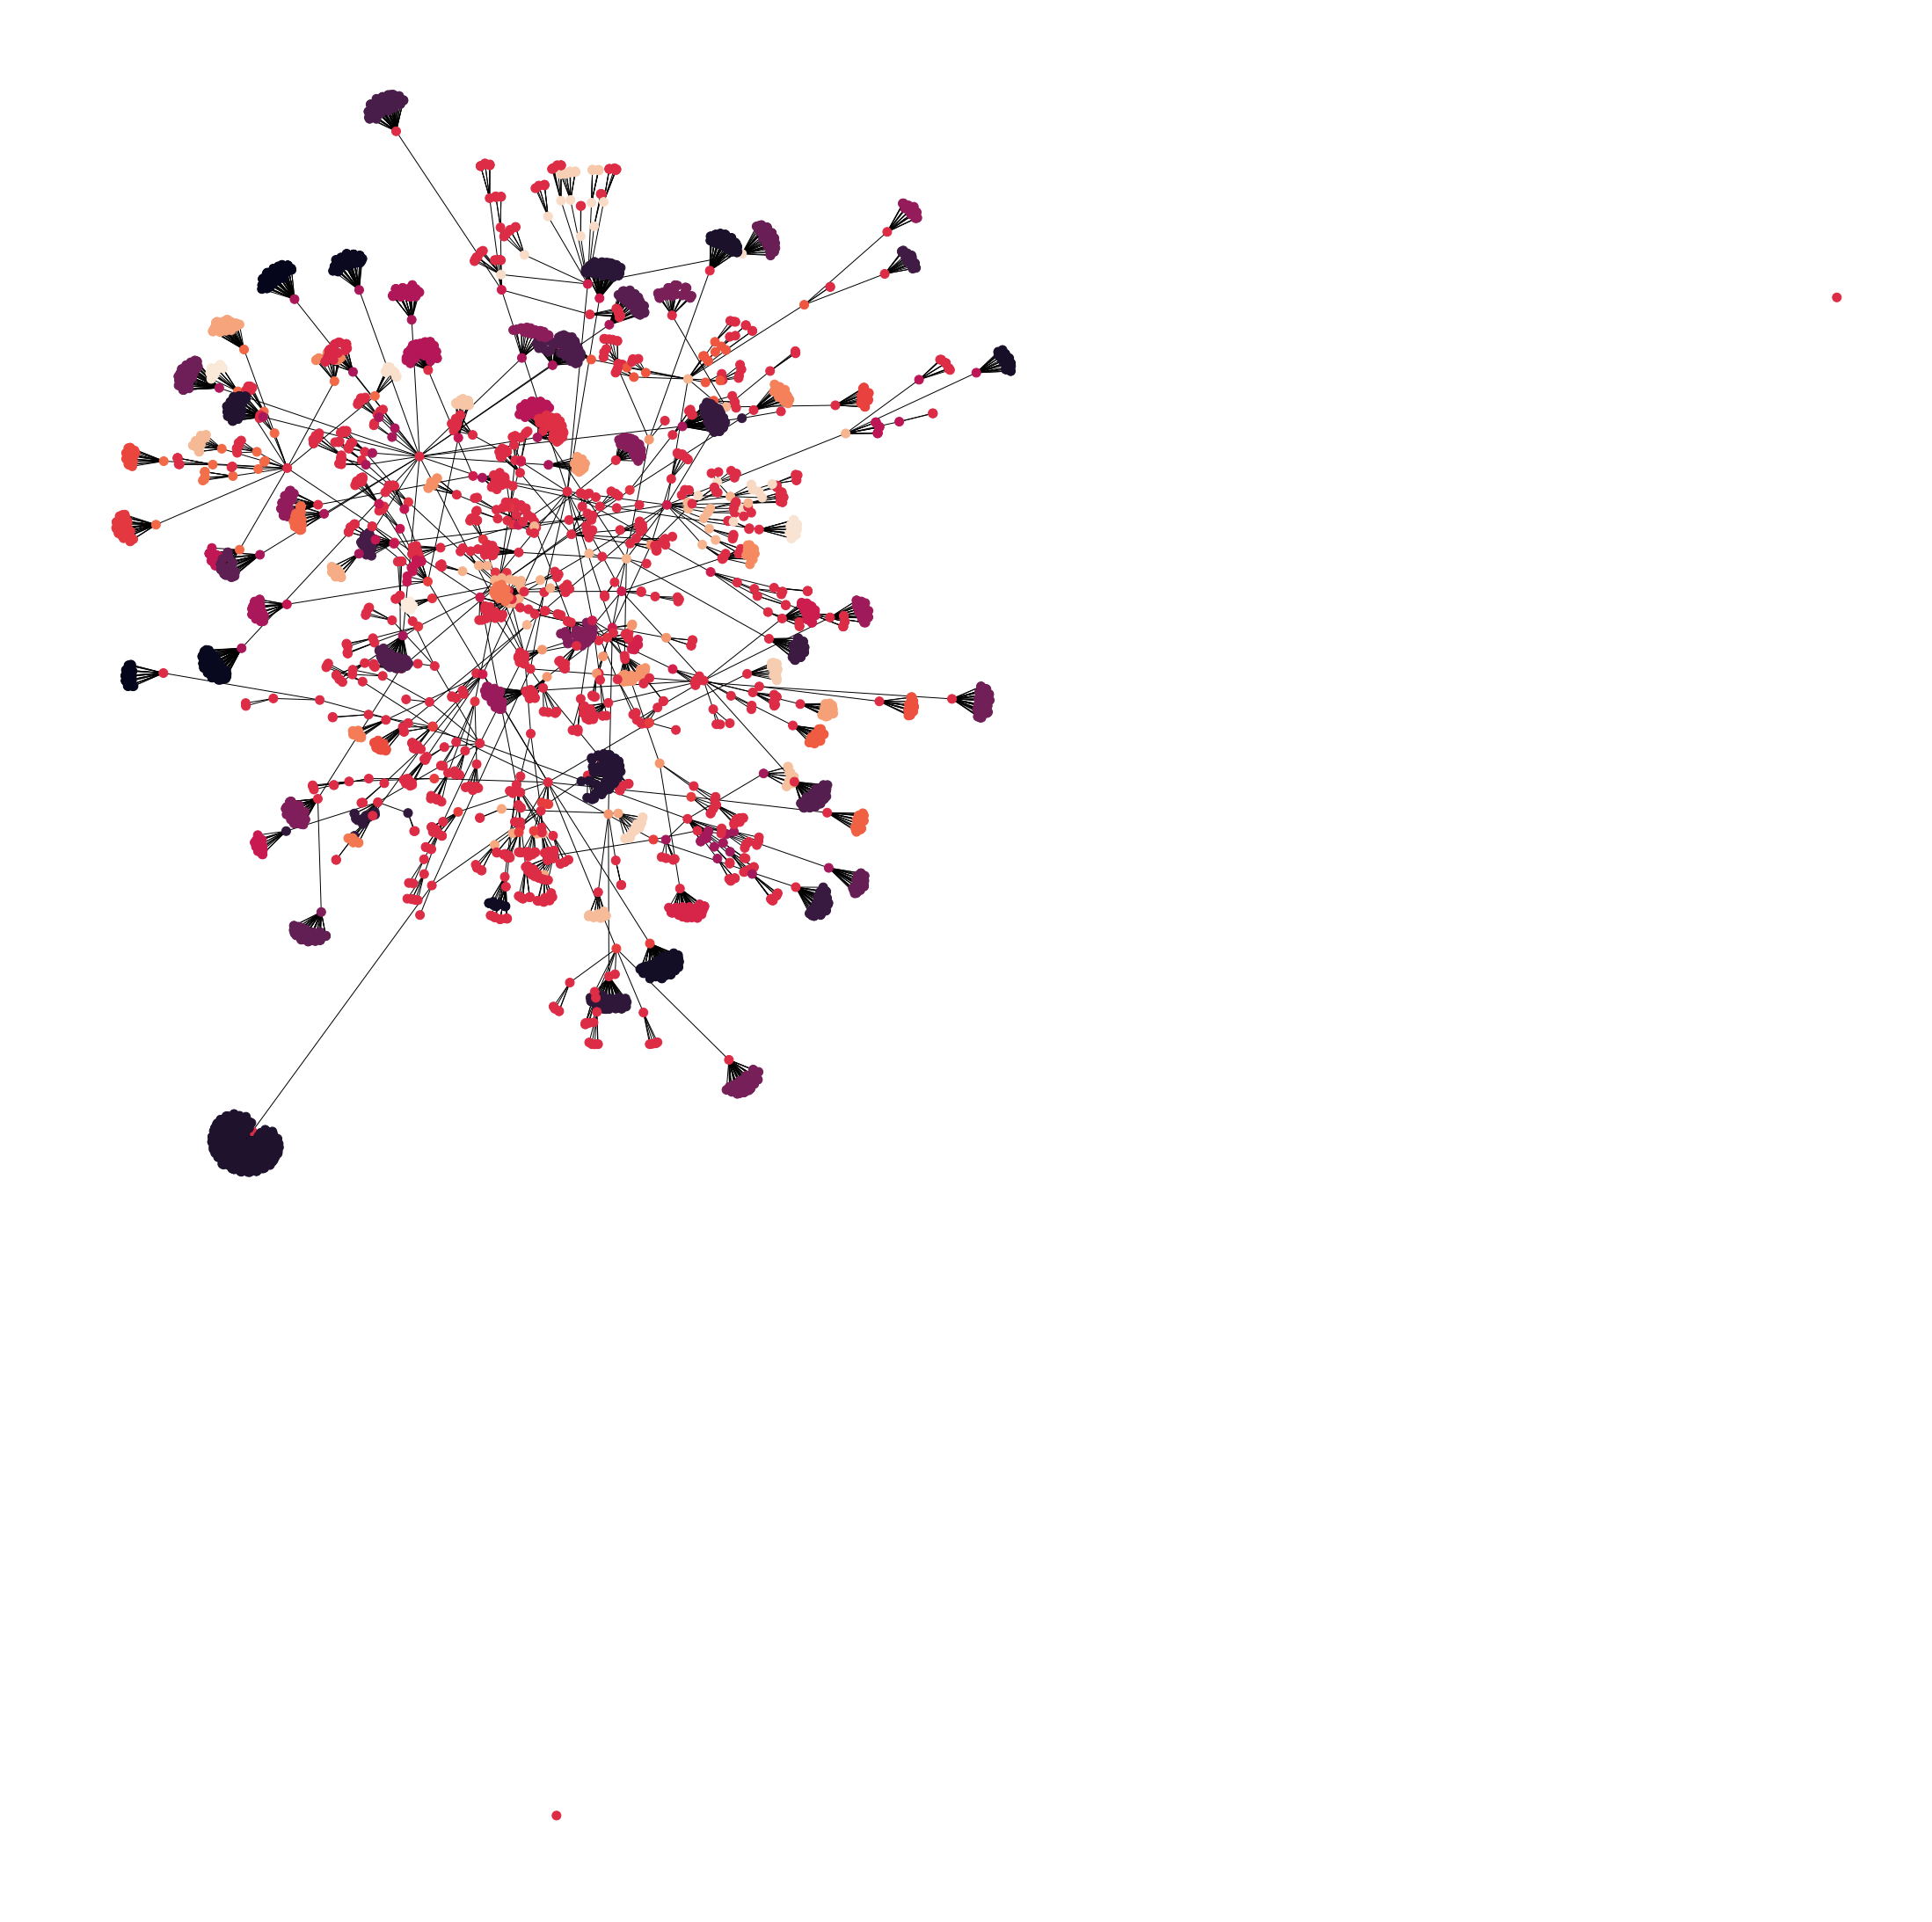

In [68]:
nx.draw_spring(G, node_size=100, 
               node_color=embedding_2d['labels'])